In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy

import seaborn as sns

folder_path = './datas/101/'
folder_path2 = './datas/100/'
pcanum = 20
tempnum = 200

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 800
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [4]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

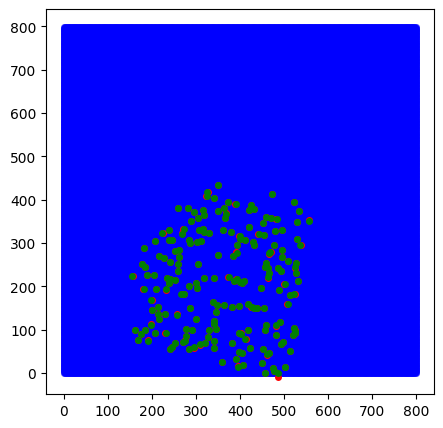

In [5]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,-pi/12);

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [6]:
datas

View of AnnData object with n_obs × n_vars = 200 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'

In [7]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9760 by 200

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 200 cells



  |======================================================================| 100%


R[write to console]: Second step: Get residuals using fitted parameters for 9760 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9760 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 3.789024 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  200 
## number of total features:  9760 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  21  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  21  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.236685413938515  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] 

In [8]:
adata1 = pd.read_csv(folder_path+"pca.csv")
adata1 = adata1.set_index(adata1.columns[0]).T
adata1.index = adata1.index.str.replace('.', '-')
similarity_matrix = 1 - cosine_similarity(adata1)
n=len(similarity_matrix);
Z = hierarchy.linkage(similarity_matrix, 'ward')

nodes1 = [node(name=str(i),son=[]) for i in range(2*n-1)]
for i in range(n):
    nodes1[i].value = adata1.iloc[i].to_numpy()
for i in range(n-1):
    nodes1[n+i].son.append(nodes1[int(Z[i][0])])
    nodes1[n+i].son.append(nodes1[int(Z[i][1])])
    nodes1[n+i].value = nodes1[n+i].son[0].value  + nodes1[n+i].son[1].value
    nodes1[n+i].value /=2


/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_10196/3124441846.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata1.index = adata1.index.str.replace('.', '-')


In [9]:
adata2 = pd.read_csv(folder_path2+"pca.csv")
adata2 = adata2.set_index(adata2.columns[0]).T
adata2.index = adata2.index.str.replace('.', '-')
similarity_matrix = 1 - cosine_similarity(adata2)
n=len(similarity_matrix);
Z = hierarchy.linkage(similarity_matrix, 'ward')

nodes2 = [node(name=str(i),son=[]) for i in range(2*n-1)]
for i in range(n):
    nodes2[i].value = adata2.iloc[i].to_numpy()
for i in range(n-1):
    nodes2[n+i].son.append(nodes2[int(Z[i][0])])
    nodes2[n+i].son.append(nodes2[int(Z[i][1])])
    nodes2[n+i].value = nodes2[n+i].son[0].value  + nodes2[n+i].son[1].value
    nodes2[n+i].value /=2


/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_10196/2141407943.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata2.index = adata2.index.str.replace('.', '-')


In [10]:
T=tree_alignment(nodes1[-1],nodes2[-1],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()


The mininum cost for alignment is 442.8285714285714
The alignment edges list is [('398', '398'), ('397', '397'), ('395', '390'), ('393', '386'), ('383', '376'), ('378', '353'), ('373', '314'), ('329', '304'), ('288', '262'), ('259', '247'), ('241', '214'), ('207', '202'), ('15', '185'), ('8', '197'), ('47', '88'), ('90', '6'), ('36', '106'), ('125', '20'), ('260', '259'), ('115', '69'), ('210', '240'), ('202', '217'), ('146', '171'), ('16', '75'), ('148', '3'), ('319', '327'), ('286', '243'), ('176', '63'), ('77', '150'), ('284', '288'), ('253', '241'), ('221', '230'), ('145', '31'), ('133', '181'), ('70', '83'), ('34', '141'), ('332', '237'), ('301', '204'), ('127', '192'), ('157', '23'), ('17', '156'), ('370', '362'), ('364', '354'), ('330', '311'), ('275', '265'), ('108', '199'), ('50', '11'), ('215', '210'), ('109', '194'), ('71', '126'), ('222', '294'), ('98', '119'), ('62', '32'), ('335', '346'), ('285', '287'), ('165', '54'), ('45', '5'), ('282', '298'), ('204', '256'), ('173', 

In [11]:
minn/2/(2*n-1)

0.5549230218403151

In [12]:
all = n;
count =0;
for i in range(n):
    if(ans.__contains__( (str(i),str(i)) ) ):
        count +=1
print(count/all);

0.0
